# EDA: HPO Matrices

This notebook explores the matrices produced by `make_matrices.py`.

**Expected files in `data_proc/`:**
- `X_hpo_weight_csr.npz`
- `X_hpo_weight_norm_csr.npz`
- `X_hpo_weightic_csr.npz`
- `X_hpo_weightic_norm_csr.npz`
- `mappings.json`

- `condition.parquet`, `feature.parquet`, `condition_feature.parquet`


In [4]:
# Config: set project root (directory that contains data_proc/)
from pathlib import Path
ROOT = Path('..')  # change this if your project is elsewhere
DP = (ROOT / 'data_proc').resolve()
DP

WindowsPath('C:/Users/T490/Downloads/genetics-ml-hpo/data_proc')

In [ ]:
# Imports and small helpers
import json
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path


def load_npz(path: Path) -> sp.csr_matrix:
    X = sp.load_npz(path)
    return X.tocsr()

def basic_stats(X: sp.csr_matrix):
    n_rows, n_cols = X.shape
    nnz = X.nnz
    density = nnz / (n_rows * n_cols) if n_rows and n_cols else float('nan')
    row_nnz = np.diff(X.indptr)
    col_nnz = np.diff(X.tocsc().indptr)
    return {
        'n_rows': int(n_rows), 'n_cols': int(n_cols), 'nnz': int(nnz), 'density': float(density),
        'row_nnz_min': int(row_nnz.min()) if row_nnz.size else 0,
        'row_nnz_max': int(row_nnz.max()) if row_nnz.size else 0,
        'row_nnz_mean': float(row_nnz.mean()) if row_nnz.size else float('nan'),
        'row_nnz_median': float(np.median(row_nnz)) if row_nnz.size else float('nan'),
        'col_nnz_min': int(col_nnz.min()) if col_nnz.size else 0,
        'col_nnz_max': int(col_nnz.max()) if col_nnz.size else 0,
        'col_nnz_mean': float(col_nnz.mean()) if col_nnz.size else float('nan'),
        'col_nnz_median': float(np.median(col_nnz)) if col_nnz.size else float('nan'),
    }

def check_row_norms(X: sp.csr_matrix, tol: float = 1e-3):
    sq = X.multiply(X).sum(axis=1).A.ravel()
    nz_mask = sq > 0
    norms = np.sqrt(np.clip(sq[nz_mask], 0.0, np.inf))
    if norms.size == 0:
        return {'nonempty_rows': 0, 'pct_within_tol': 100.0, 'mean_norm': 0.0, 'std_norm': 0.0}
    within = ((norms >= 1 - tol) & (norms <= 1 + tol)).mean() * 100.0
    return {
        'nonempty_rows': int(norms.size),
        'pct_within_tol': float(within),
        'mean_norm': float(norms.mean()),
        'std_norm': float(norms.std()),
    }

def topk_indices_by_degree(X: sp.csr_matrix, k: int = 20):
    row_counts = np.diff(X.indptr)
    col_counts = np.diff(X.tocsc().indptr)
    top_rows = np.argsort(-row_counts)[:k]
    top_cols = np.argsort(-col_counts)[:k]
    return top_rows, top_cols

def cosine_sim_topk(X_norm: sp.csr_matrix, idx: int, k: int = 10):
    x = X_norm.getrow(idx)
    sims = (X_norm @ x.T).toarray().ravel()
    sims[idx] = -np.inf
    top = np.argpartition(-sims, range(k))[:k]
    top = top[np.argsort(-sims[top])]
    return [(int(i), float(sims[i])) for i in top]

def hist_plot(values, title):
    plt.figure()
    plt.hist(values, bins=50)
    plt.title(title)
    plt.xlabel('value')
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()

def spy_plot(X: sp.csr_matrix, title: str, max_rows: int = 300, max_cols: int = 300):
    r = min(max_rows, X.shape[0])
    c = min(max_cols, X.shape[1])
    plt.figure()
    plt.spy(X[:r, :c], markersize=1)
    plt.title(f"{title} (top-left {r}×{c})")
    plt.tight_layout()
    plt.show()


In [6]:
# Load matrices and mappings
Xw_path   = DP / 'X_hpo_weight_csr.npz'
Xwn_path  = DP / 'X_hpo_weight_norm_csr.npz'
Xwic_path = DP / 'X_hpo_weightic_csr.npz'
Xwicn_path= DP / 'X_hpo_weightic_norm_csr.npz'
map_path  = DP / 'mappings.json'

for p in [Xw_path, Xwn_path, Xwic_path, Xwicn_path, map_path]:
    if not p.exists():
        raise FileNotFoundError(f"Missing {p}. Run make_matrices.py first.")

Xw   = load_npz(Xw_path)
Xwn  = load_npz(Xwn_path)
Xwic = load_npz(Xwic_path)
Xwicn= load_npz(Xwicn_path)

with open(map_path, 'r', encoding='utf-8') as f:
    mappings = json.load(f)
cond_ids = mappings.get('cond_ids', [])
feat_ids = mappings.get('feat_ids', [])
len(cond_ids), len(feat_ids)

(12724, 11420)

## Core statistics

In [7]:
stats_w   = basic_stats(Xw)
stats_wn  = basic_stats(Xwn)
stats_wic = basic_stats(Xwic)
stats_wicn= basic_stats(Xwicn)
stats_w, stats_wn, stats_wic, stats_wicn

({'n_rows': 12724,
  'n_cols': 11420,
  'nnz': 272025,
  'density': 0.0018720569427384906,
  'row_nnz_min': 1,
  'row_nnz_max': 211,
  'row_nnz_mean': 21.378890286073563,
  'row_nnz_median': 16.0,
  'col_nnz_min': 1,
  'col_nnz_max': 4199,
  'col_nnz_mean': 23.820052539404553,
  'col_nnz_median': 4.0},
 {'n_rows': 12724,
  'n_cols': 11420,
  'nnz': 272025,
  'density': 0.0018720569427384906,
  'row_nnz_min': 1,
  'row_nnz_max': 211,
  'row_nnz_mean': 21.378890286073563,
  'row_nnz_median': 16.0,
  'col_nnz_min': 1,
  'col_nnz_max': 4199,
  'col_nnz_mean': 23.820052539404553,
  'col_nnz_median': 4.0},
 {'n_rows': 12724,
  'n_cols': 11420,
  'nnz': 272025,
  'density': 0.0018720569427384906,
  'row_nnz_min': 1,
  'row_nnz_max': 211,
  'row_nnz_mean': 21.378890286073563,
  'row_nnz_median': 16.0,
  'col_nnz_min': 1,
  'col_nnz_max': 4199,
  'col_nnz_mean': 23.820052539404553,
  'col_nnz_median': 4.0},
 {'n_rows': 12724,
  'n_cols': 11420,
  'nnz': 272025,
  'density': 0.001872056942738490

## Normalization checks (L2 row norms)

In [8]:
norm_wn   = check_row_norms(Xwn)
norm_wicn = check_row_norms(Xwicn)
norm_wn, norm_wicn

({'nonempty_rows': 12724,
  'pct_within_tol': 100.0,
  'mean_norm': 1.0,
  'std_norm': 5.858883866949327e-08},
 {'nonempty_rows': 12724,
  'pct_within_tol': 100.0,
  'mean_norm': 1.0,
  'std_norm': 5.2956785623337055e-08})

## Degree distributions and value histograms

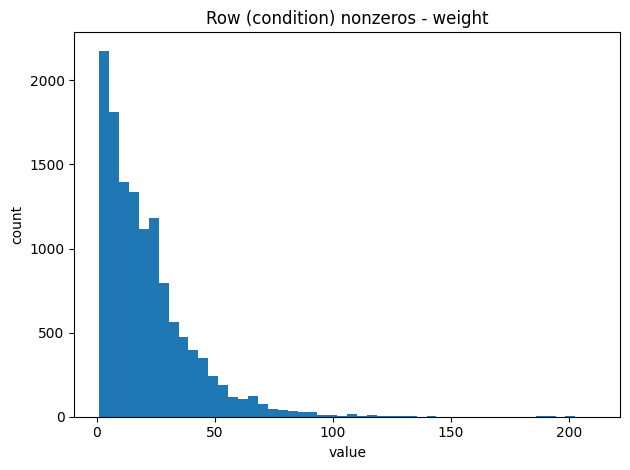

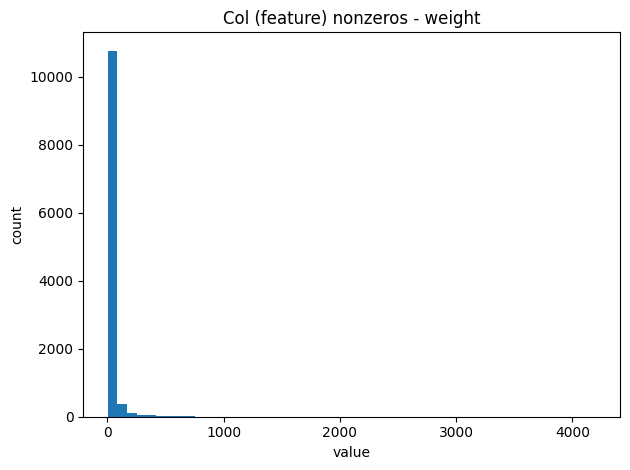

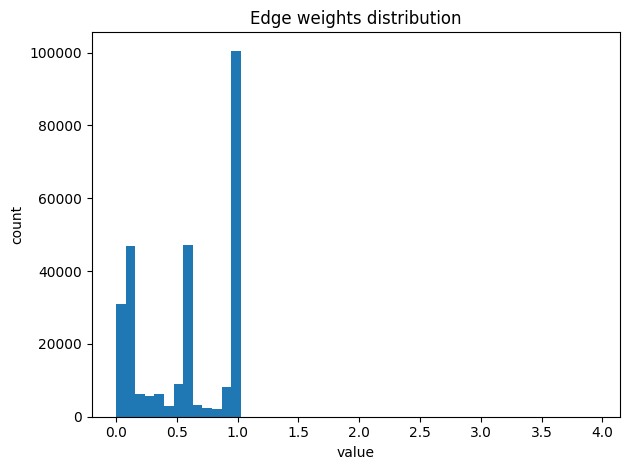

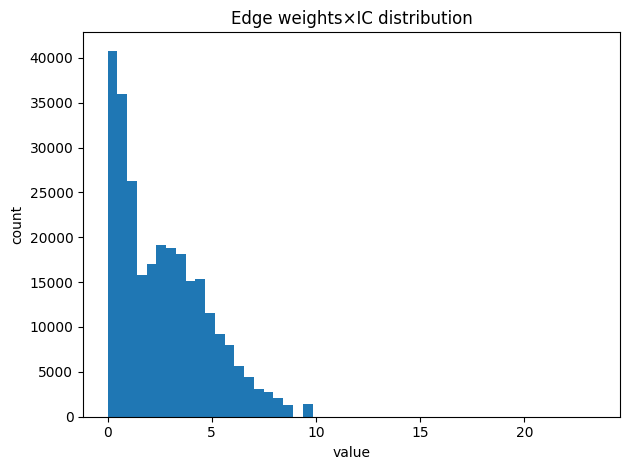

In [9]:
row_deg = np.diff(Xw.indptr)
col_deg = np.diff(Xw.tocsc().indptr)
hist_plot(row_deg, 'Row (condition) nonzeros - weight')
hist_plot(col_deg, 'Col (feature) nonzeros - weight')
hist_plot(Xw.data, 'Edge weights distribution')
hist_plot(Xwic.data, 'Edge weights×IC distribution')

## Sparsity (spy) plots

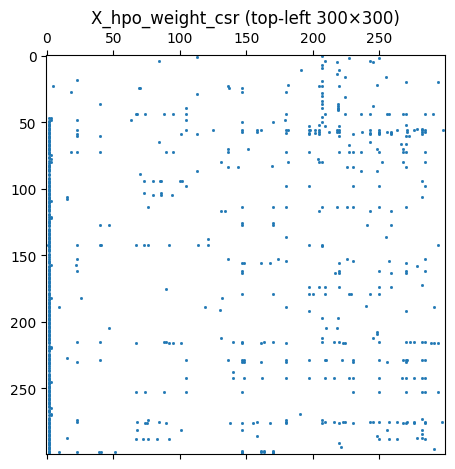

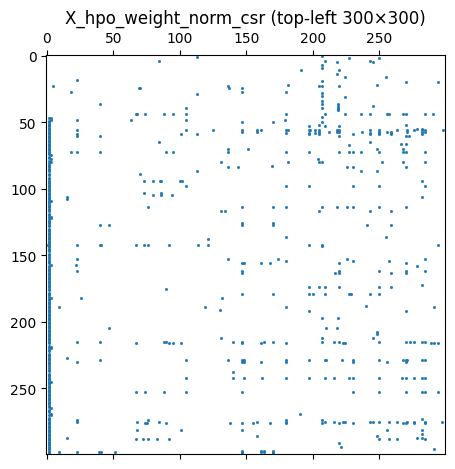

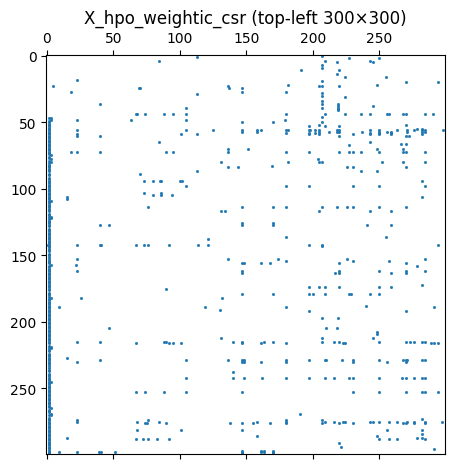

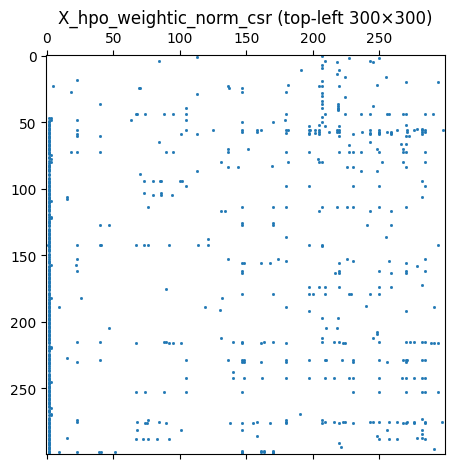

In [10]:
spy_plot(Xw,   'X_hpo_weight_csr')
spy_plot(Xwn,  'X_hpo_weight_norm_csr')
spy_plot(Xwic, 'X_hpo_weightic_csr')
spy_plot(Xwicn,'X_hpo_weightic_norm_csr')

## Top-degree conditions / features

In [11]:
top_rows, top_cols = topk_indices_by_degree(Xw, k=20)
top_rows, top_cols

(array([ 8392,  2915,  3028,  6007,  2316,  7741, 12270,   714,  7760,
         9922,  1175,   274,  9416,  6251,  2908,  3527, 11486,  3730,
          346,  4997]),
 array([   3,    2,  945,  935,  934, 2773,  937,  207, 2533, 1886, 2529,
         250,  362,  270, 6421,  488, 1088,  575,  284,  936]))

In [ ]:
# paths
cond_pq = DP / "condition.parquet"

# row nnz (how many phenotype links each condition has)
row_nnz = pd.Series(np.diff(Xw.indptr), name="phenotype_count")

# top-k indices you already computed
k = 20
top_rows_idx = np.argsort(-row_nnz.values)[:k]

# build a small table using mappings.json (IDs) + condition.parquet (names)
cond_table = pd.DataFrame({
    "row_index": top_rows_idx,
    "condition_id": [cond_ids[i] if i < len(cond_ids) else None for i in top_rows_idx],
    "phenotype_count": row_nnz.iloc[top_rows_idx].values
})

# enrich with condition names if parquet is present
if cond_pq.exists():
    cond_df = pd.read_parquet(cond_pq).astype({"condition_id": str})
    cond_table = cond_table.merge(cond_df[["condition_id", "name"]], on="condition_id", how="left")

# nicer ordering
cond_table = cond_table[["row_index", "condition_id", "name", "phenotype_count"]].sort_values(
    "phenotype_count", ascending=False
).reset_index(drop=True)

cond_table


,row_index,condition_id,name,phenotype_count
0,8392,OMIM:620851,ReNU syndrome,211
1,2915,OMIM:300868,Multiple congenital anomalies-hypotonia-seizur...,202
2,3028,OMIM:301118,"Intellectual developmental disorder, X-linked ...",201
3,6007,OMIM:615829,Xia-Gibbs syndrome,192
4,2316,OMIM:256810,Mitochondrial DNA depletion syndrome 6 (hepato...,190
5,7741,OMIM:619475,"Developmental delay, impaired speech, and beha...",188
6,12270,ORPHA:904,Williams syndrome,186
7,714,OMIM:147920,Kabuki syndrome 1,183
8,714,OMIM:147920,Kabuki Syndrome 1,183
9,7760,OMIM:619503,Neurodevelopmental disorder with hypotonia and...,154


In [16]:
feat_pq = DP / "feature.parquet"

# column nnz (how many conditions mention each phenotype)
col_nnz = pd.Series(np.diff(Xw.tocsc().indptr), name="condition_count")

# top-k columns by degree
k = 20
top_cols_idx = np.argsort(-col_nnz.values)[:k]

# table using mappings.json (HPO IDs) + feature.parquet (labels & IC)
feat_table = pd.DataFrame({
    "col_index": top_cols_idx,
    "feature_id": [feat_ids[j] if j < len(feat_ids) else None for j in top_cols_idx],
    "condition_count": col_nnz.iloc[top_cols_idx].values
})

if feat_pq.exists():
    feat_df = pd.read_parquet(feat_pq).astype({"feature_id": str})
    keep_cols = ["feature_id", "label"] + (["ic"] if "ic" in feat_df.columns else [])
    feat_table = feat_table.merge(feat_df[keep_cols], on="feature_id", how="left")

feat_table = feat_table[[c for c in ["col_index","feature_id","label","ic","condition_count"] if c in feat_table.columns]]\
                       .sort_values("condition_count", ascending=False).reset_index(drop=True)

feat_table


,col_index,feature_id,label,ic,condition_count
0,3,HP:0000007,Autosomal recessive inheritance,1.114911,4199
1,2,HP:0000006,Autosomal dominant inheritance,1.293857,3511
2,945,HP:0001263,Global developmental delay,1.638278,2488
3,935,HP:0001250,Seizure,1.648784,2462
4,934,HP:0001249,Intellectual disability,1.663926,2425
5,2773,HP:0004322,Short stature,1.959197,1805
6,937,HP:0001252,Hypotonia,1.982741,1763
7,207,HP:0000252,Microcephaly,2.046561,1654
8,2533,HP:0003593,Infantile onset,2.120576,1536
9,1886,HP:0002650,Scoliosis,2.250394,1349


## Retrieval sanity checks (cosine neighbors)
Run on the **normalized** matrices.

In [12]:
rng = np.random.default_rng(7)
k = 10
probe_rows = min(5, Xwn.shape[0])
probes = rng.choice(Xwn.shape[0], size=probe_rows, replace=False)
report = []
for idx in probes:
    nn_wn   = cosine_sim_topk(Xwn, idx, k=k)
    nn_wicn = cosine_sim_topk(Xwicn, idx, k=k)
    report.append({
        'row_index': int(idx),
        'condition_id': cond_ids[idx] if idx < len(cond_ids) else None,
        'neighbors_weight_norm': nn_wn,
        'neighbors_weightic_norm': nn_wicn,
    })
report

[{'row_index': 7951,
  'condition_id': 'OMIM:619872',
  'neighbors_weight_norm': [(8219, 0.57732093334198),
   (5786, 0.5126535892486572),
   (6540, 0.5083401799201965),
   (7278, 0.4593152105808258),
   (633, 0.45485883951187134),
   (5959, 0.45133543014526367),
   (6391, 0.45116034150123596),
   (6278, 0.4472135603427887),
   (5364, 0.4402254819869995),
   (6179, 0.4402254819869995)],
  'neighbors_weightic_norm': [(2087, 0.2041710615158081),
   (4924, 0.13620619475841522),
   (11234, 0.11664731055498123),
   (8219, 0.10558291524648666),
   (3797, 0.06524369865655899),
   (4765, 0.06116374582052231),
   (1194, 0.05267695337533951),
   (552, 0.04903726279735565),
   (6714, 0.04654395580291748),
   (1356, 0.046107836067676544)]},
 {'row_index': 8704,
  'condition_id': 'ORPHA:137608',
  'neighbors_weight_norm': [(11619, 0.35002464056015015),
   (11620, 0.32770785689353943),
   (10437, 0.3206537961959839),
   (11073, 0.286317378282547),
   (9795, 0.24152541160583496),
   (9796, 0.24152541

## Parquet-based extras

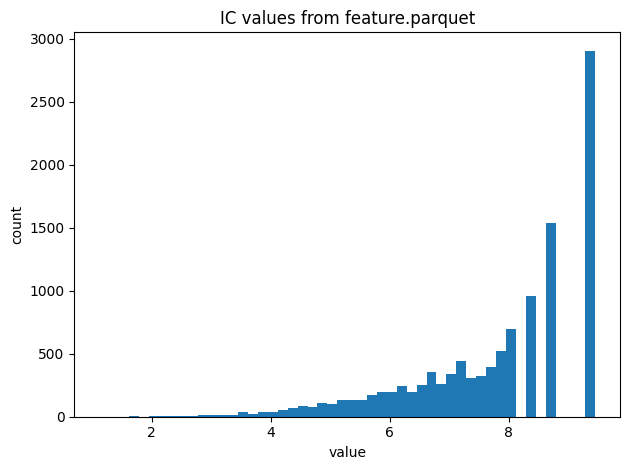

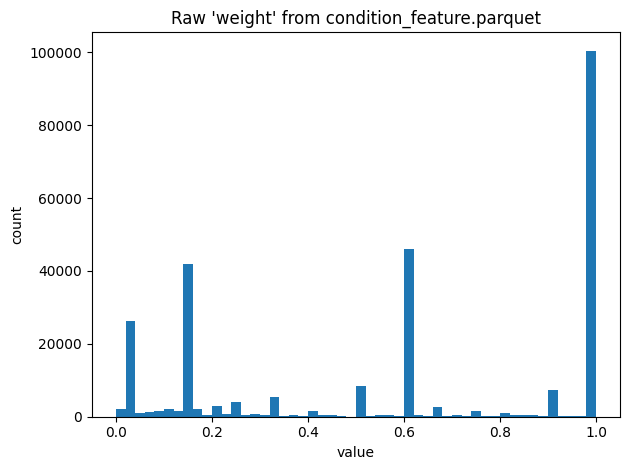

In [14]:

cond_pq = (DP / 'condition.parquet')
feat_pq = (DP / 'feature.parquet')
cf_pq   = (DP / 'condition_feature.parquet')
if feat_pq.exists():
    feat_df = pd.read_parquet(feat_pq)
    if 'ic' in feat_df.columns:
        ic_vals = feat_df['ic'].astype(float).values
        hist_plot(ic_vals, 'IC values from feature.parquet')
        {
            'ic_min': float(np.min(ic_vals)),
            'ic_median': float(np.median(ic_vals)),
            'ic_mean': float(np.mean(ic_vals)),
            'ic_max': float(np.max(ic_vals)),
        }
if cf_pq.exists():
    cf_df = pd.read_parquet(cf_pq)
    if 'weight' in cf_df.columns:
        wvals = cf_df['weight'].astype(float).values
        hist_plot(wvals, "Raw 'weight' from condition_feature.parquet")
        {'quantiles': [float(q) for q in np.quantile(wvals, [0, 0.25, 0.5, 0.75, 1])]}
